# Volatility Predictor
Volatility predictor that utilizes a variety of techniques to predict the volatility of an asset.  Machine Learning algorithms are designed including polynomial regression and Decision Trees.  Volatility is priced and compared on a relative and absolute level.   

# Objective 
Predict the focus asset’s vol by using it’s own history and using the relationship between that asset and other similar assets within that class.
1. Download csv daily price history for the past 10 years from barcharts.com for interested assets. For this project I downloaded the price history a variety of currencies. Each currency is a separate csv file. I downloaded price history for the EUR/USD, JPY/USD, GBP/USD, CAD/USD, AUD/USD. Each download file includes the date, symbol, Open, High, Low, Close, Change, Volume and Open Interest.
2. Write functions for converting rates of change into vol and vol into rates of change.
3. Process files for time and exploratory data analysis.
4. Write functions for volatility prediction by sampling
5. Write processing functions for vol predictions by Machine Learning
6. Write Regression algorithms for vol predictions.
7. Write Decision Tree classification algorithm for vol predictions.
8. Set variables for predictions
9. Make predictions and score predictions, using sampling, regression and decision trees.
10. Compare and analyze results.

In [1]:
#import libraries 
import pandas as pd
import numpy as np

from IPython.display import display # Allows the use of display() for DataFrames


import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from datetime import datetime, timedelta

import random
from random import sample 

# Import the classifier from sklearn
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import precision_recall_fscore_support

In [2]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [3]:
from sklearn.metrics import r2_score

In [4]:
#imports from sklearn library

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

import seaborn as sn

In [5]:
pd.options.display.max_columns = None

In [6]:
#function to read and format csv file 
#input: file
#output: df without NaNs, proper format

def read_format(file):
    df = pd.read_csv(file, header=1, parse_dates=True)
    df = df.drop(df.tail(2).index)
    df['Open Interest'].fillna(method='ffill', inplace=True)
    
    
    return df

## Period Volatility as Basis for Pricing Options 

Volatility is usually quoted annually but analyzed on a daily basis.  The conversion from annual to any period is not
linear, but follows the formula in vol_convert. Therefore if the annual volatility is 16%, we would expect an approximate daily standard deviation of 1%. In option trading we would refer to this as the approximate break even rate on an option using the Black-Scholes formula for pricing.  Due to convexity an option holder can rehedge (scalp) their position. This leads to positive income for the option holder and offsets the natural decay of the option. vol_convert is returning the break even percentage move scalp that offsets the natural decay (theta) of the option.  Therefore one can back into the volatility of an option with the period percentage moves of its underlying.  

## Convert Vols and Rates

In [7]:
'''
    Objective: Convert annualized volatility to a rate
    INPUT:
    vol -    the annualized volatility rate or annualized standard deviation in percentage terms
    period - number of trading periods in a year, traders usually 
             look for a daily rate since they manage their positions 
             daily.  There are 255 trading days in a year, so that is the default period
    
    OUTPUT:
    rate - percentage rate for a one standard deviation move in a given period
'''
def vol_convert(vol, period = 255):
    rate = round(vol/((np.sqrt(period)*100)),6)
    return rate

In [8]:
'''
    Objective: Convert rate to a annualized volatility 
    INPUT:
    rate -   percentage rate for a one standard deviation move in a given period
    period - number of trading periods in a year, traders usually 
             look for a daily rate since they manage their positions 
             daily.  There are 255 trading days in a year, so that is the default period
    
    OUTPUT:
    vol - the annualized volatility rate or annualized standard deviation in percentage terms
'''


def rate_convert(rate, period = 255):
    vol = round((rate*100*(np.sqrt(period))),2)
    
    return vol

## Variables

In [9]:
# set files to a variable
file_one = r"C:\Users\Matt\Desktop\eur_data.csv"
file_two = r"C:\Users\Matt\Desktop\jpy_data.csv"
file_three = r"C:\Users\Matt\Desktop\bp_data.csv"
file_four = r"C:\Users\Matt\Desktop\ca_data.csv"
file_five = r"C:\Users\Matt\Desktop\au_data.csv"

In [10]:
# read in and clean csv files to a data frame 
eur = read_format(file_one)
jpy = read_format(file_two)
bp =  read_format(file_three)
ca =  read_format(file_four)
au =  read_format(file_five)

In [11]:
#implied volatilities for each asset
eu_vol = 4.80
jpy_vol = 5.65
bp_vol = 9
au_vol = 6.55
ca_vol = 4.32

In [12]:
#files and vols to associate 
#focus asset defined at the asset whose vol one is looking to predict
#the sub assets and vols are the predictor assets
#the at the money price of the asset
focus = eur.copy()
sub1 = jpy.copy()
sub2 = bp.copy()
sub3 = ca.copy()
sub4 = au.copy()

focus_vol = eu_vol
focus_file = file_two

sub_vol = jpy_vol
sub_file = file_two
atm_price = 1.1150

sub2_vol = bp_vol
sub3_vol = ca_vol
sub4_vol = au_vol

In [13]:
#range of days for sample analysis, realized volatility mean and confidence level above vol
#range of days for sample straddle analysis
#number of days to sample, generally the number of business days until option expiration
#days_to_train, previous number of days in the data set to train to ML models, regression and decision trees
sample_start_date = '2019-09-01'
sample_end_date = '2019-12-08'
days_to_train = 500
number_of_days_to_sample = 60


In [14]:
#variables for Decision Tree

fv_dataframe = read_format(focus_file).copy()
dt_df = fv_dataframe.iloc[-days_to_train:].copy()
start_vol = 3.5
end_vol = 8
step = .15
hist_period1 = 15
hist_period2 = 22
hist_period3 = 44
volume_period1 = 10
volume_period2 = 20
forward_vol_period = number_of_days_to_sample

## Time Analysis

In [15]:
'''
    Objective: Convert dataframe with datetime so user can query for a specif range of dates or times
    INPUT:
    dataframe - the dataframe to convert, generally the asset which we will focus and attempt to predict vol
    hist1 - the number of days back to calculate the average historical realized volatility
    
    OUTPUT:
    rate - dataframe in datetime
'''


def process_for_time_analysis(dataframe, hist1 = 20):
    
    
    
    dataframe['percent_move'] = dataframe['Change'] / dataframe['Close']
    
    dataframe['abs_percent_move'] = dataframe['Change'].abs() / dataframe['Close']
    
    dataframe['abs_change'] = rate_convert(dataframe['Change'].abs() / dataframe['Close'])
    
    
    
    dataframe['high_move'] = rate_convert((((dataframe.High - dataframe.Close.shift(1))/dataframe['Close']).abs()))
    dataframe['low_move'] = rate_convert((((dataframe.Low - dataframe.Close.shift(1))/dataframe['Close']).abs()))
    dataframe['max_move'] = dataframe[['high_move', 'low_move']].max(axis=1)
    
    dataframe['avg_max_close'] = dataframe[['max_move', 'abs_change']].mean(axis=1)
    
    dataframe['Realized_historical_vol'] = dataframe.avg_max_close.rolling(window=hist1).mean()
    
    dataframe['historical_volume'] = dataframe.Volume.rolling(window=hist1).mean()
    
    dataframe['Date Time'] = pd.to_datetime(dataframe['Date Time'])
    dataframe['Year'] = dataframe['Date Time'].dt.year
    dataframe['month'] = dataframe['Date Time'].dt.month
    dataframe['weekday'] = dataframe['Date Time'].dt.weekday_name
    
    dataframe = dataframe.set_index('Date Time')
    
    dataframe = dataframe.dropna(how = 'any')
    
    return dataframe 

In [16]:
#copy the focus asset dataframe
df_for_time = focus.copy()

In [17]:
#process the focus dataframe for datetime 
time_df = process_for_time_analysis(df_for_time)

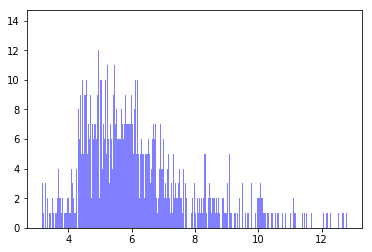

In [18]:
#look at the realized historical vol distribution

num_bins = 500
x = time_df['Realized_historical_vol']
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [19]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

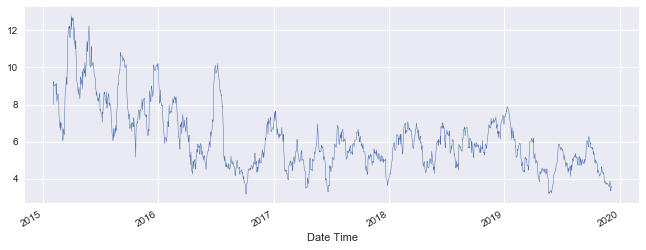

In [20]:
#graph realized historical vol over time 
time_df['Realized_historical_vol'].plot(linewidth=0.5);

In [21]:
#create a dataframe for this current year
this_year = time_df.loc['2019']

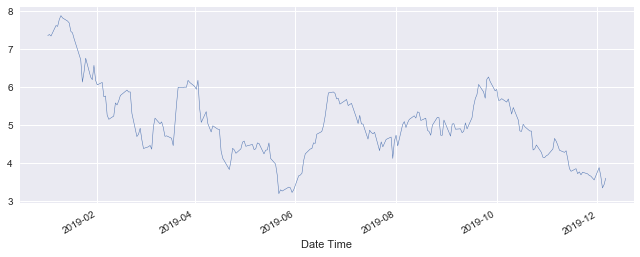

In [22]:
#graph realized historical vol over the past year
this_year['Realized_historical_vol'].plot(linewidth=0.5);

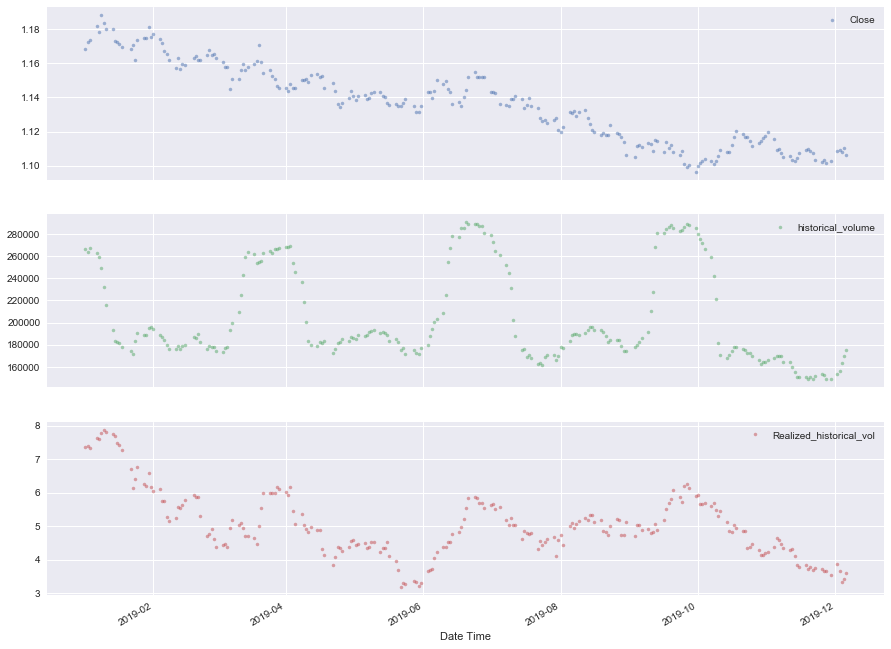

In [23]:
#graph the closing price, historic vol and historic volume vertically for comparison over time 

cols_plot = ['Close', 'historical_volume', 'Realized_historical_vol']
axes = this_year[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(15, 12), subplots=True)
#for ax in axes:
#   ax.set_ylabel('Title')

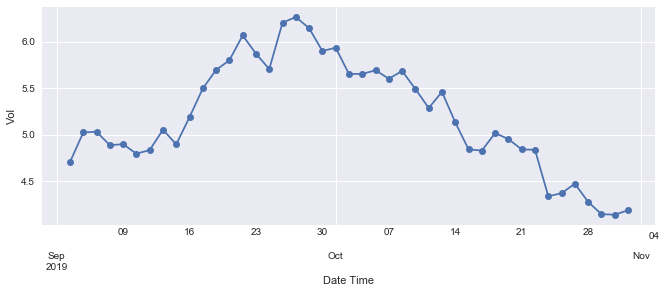

In [24]:
#graph realized historical vol over the past few months

ax = time_df.loc['2019-09':'2019-10', 'Realized_historical_vol'].plot(marker='o', linestyle='-')
ax.set_ylabel('Vol');

Text(0.5,1,'Sep-October 2019 Historical_Vol')

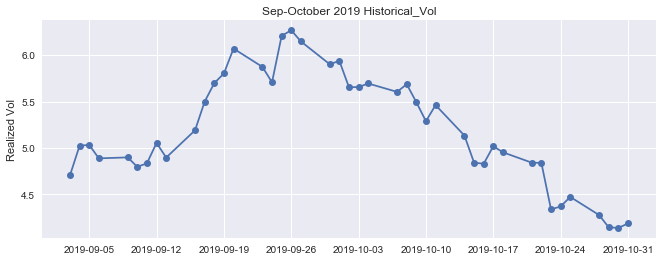

In [25]:
fig, ax = plt.subplots()
ax.plot(time_df.loc['2019-09':'2019-10', 'Realized_historical_vol'], marker='o', linestyle='-')
ax.set_ylabel('Realized Vol')
ax.set_title('Sep-October 2019 Historical_Vol')


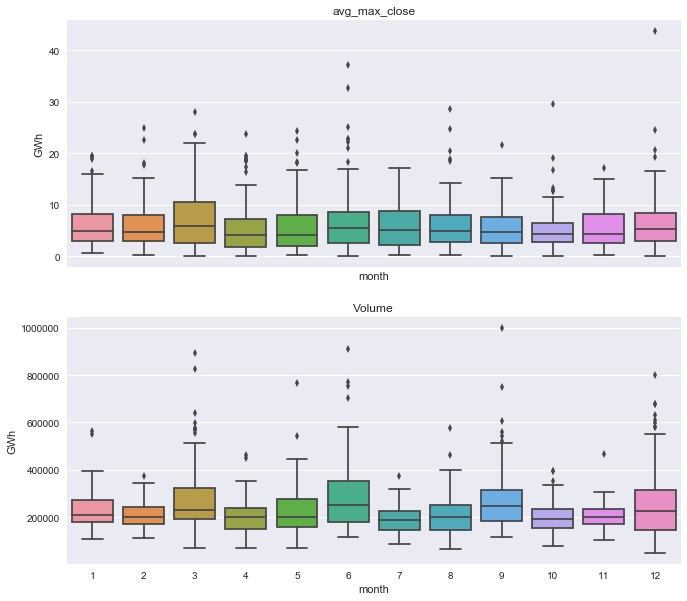

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['avg_max_close', 'Volume'], axes):
    sns.boxplot(data=time_df, x='month', y=name, ax=ax)
    ax.set_ylabel('GWh')
    ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

We can see that the volatility is erratic and does not trend.  These time series charts show that volatility has dramatic swings.  This makes predicting an asset’s volatility difficult without incorporating other techniques.  

When we graphed the realized volatility against other possible predictors to see if any relationship exists.    Looking at the graphs  we start to see similar shapes forming between price and volume.  Visually you start to see some correlation between these variables.  Running some machine learning algorithms would allow us to see if these variables are actual predictors of realized volatility as opposed to mere correlation.  Machine Learning algorithms would also allow us to define this relationship.  

## Sample Data
    

In [27]:
#time period for the sampling
range_of_days = time_df.loc[sample_start_date : sample_end_date]


In [28]:
'''
    Objective:  sample a dataframe for the historical volatility, find the mean over the iterations and probability 
                that vol is greater than a certain vol over that period.  
    INPUT:
    dataframe: the dataframe to sample from
    num_days_to_sample: the number of days to sample
    iterations: how many iterations
    vol_to_compare: volatility to calculate what percentage of the iterations were greater 
    
    OUTPUT:
    The number of days, the mean vol, the standard deviation and percentage above the vol_to_compare
'''


def hist_move_sampling(df, num_days_to_sample, iterations, vol_to_compare, replace=False):
    x = 0
    list_of_means = []
    while x < iterations:
        the_list_of_moves = df['abs_percent_move'].sample(n=num_days_to_sample, replace = replace).values
        mean_of_moves = rate_convert(np.mean(the_list_of_moves))
        list_of_means.append(mean_of_moves)
    
        x = x + 1 
    mean = round(np.mean(list_of_means), 2)
    standard_deviation = round(np.std(list_of_means), 2)
    per_above_vol = round((len([i for i in list_of_means if i > vol_to_compare]) )/iterations, 4)
    
    print('The date range includes',len(df), 'days')
    print(num_days_to_sample, 'days were sampled, out of the', len(df), 'days')
    print('The mean vol is:', mean)
    print('The standard deviation is:', standard_deviation)
    print('The percentage of sample groups that had mean volatilities above', vol_to_compare, 'is:',
          per_above_vol)
    

In [29]:
#helper function that takes a list of absolute percentage moves and a starting price and returns the ending price

def price_sim(the_list, starting_price):
    up_down = [1,-1]
    price = starting_price
    for x in the_list:
        day = random.choice(up_down)
        move = 1 + (day * x)
        price = price * move 
        
    return price 
    
    

In [30]:
#helper function that takes a list of percentage moves and a starting price and returns the ending price

def price_sim_more(the_list, starting_price):
    price = starting_price
    for x in the_list:
        move = 1 + x
        price = price * move 
        
    return price 
    

## Predict Straddle Price from Sampling Historical Data

Description of a straddle:  https://www.investopedia.com/terms/s/straddle.asp

In [31]:
'''
    Objective: return an asset's straddle price by randomly sampling daily moves of an asset in a dataframe 
    INPUT:
    dataframe: the dataframe to sample, generally includes the data about the asset
                which we will focus 
    iterations:  the number of iterations
    starting_price: starting price of the asset before any daily moves have been applied.  
    
    OUTPUT:
    rate - straddle price 
'''


def sim_option_value(df, iterations, sample_size, starting_price, replace = False):
    x = 0
    simulated_prices = []
    while x < iterations:
        list_of_moves = df['percent_move'].sample(n=sample_size, replace = replace).values
        end_price = price_sim_more(list_of_moves, starting_price)
        simulated_prices.append(end_price)
    
        x = x + 1 
    mean = np.mean(simulated_prices)
    option_value = (mean - starting_price)
    straddle_price = np.abs((option_value * 2))
    
    return round(straddle_price, 5)
    
    
    

## Historical Volatility and Ranges 
Since volatility is the basis for pricing options, any gauge that helps predict future volatility would 
be a valuable tool.  Predicting the level of future volatility is not straightforward and may not be the same in 
every market.  This is why machine learning algorithms could be helpful.  Machine Learning algorithms could comb through 
historical data in a market and learn from the experience which situations produced future levels of volatility.  


Here we process the dataframes to show the future volatility.  From a certain point in time, we can look ahead and take the average volatility for a certain period.  That is the forward volatility.  From there we can measure that against the current known variables.  That includes the historical volatility (forward volatility backwards), volume and open interest.  

## Measuring Volatility (Moves)

In [32]:

'''
    Objective: process dataset ready for machine learning, create columns that measure previous and future movement 
    INPUTS:
    dataframe - dataframe from read_format
    hist1,hist2,hist3 - the historical time periods (days) to average moves for ML input
    volume1, volume2 - the historical time periods (days) to average volume for ML input
    forward_vol_period - the forward time period (days) to average moves for ML input
    question_vol - the volatility we are testing in the forward time period to 
                   produce an output column value of 1 or 0.   
    cushion - any additional cushion to the question_vol.  Margin of error for a trade to be considered.  
    
    OUTPUT:
            Dataframe that is ready for ML processing.  
            A dataframe that has historical movement values, future movement values and a column that measures
            if the future volatility is greater than the question_vol.  For example, on a certain date we have 
            the price action of the past and future.  This dataframe will take various measures of past movements and 
            a measure of future movements.  It will then create a column that tests if the future movement was 
            greater than the question_vol.  This is our output column for ML.  
'''
def process(dataframe, hist1, hist2, hist3, volume1, volume2, forward_vol_period, question_vol, cushion):
    
    
    dataframe['abs_change'] = dataframe['Change'].abs() / dataframe['Close']
    
    dataframe['high_move'] = (((dataframe.High - dataframe.Close.shift(1))/dataframe['Close']).abs())
    dataframe['low_move'] = (((dataframe.Low - dataframe.Close.shift(1))/dataframe['Close']).abs())
    dataframe['max_move'] = dataframe[['high_move', 'low_move']].max(axis=1)
    
    dataframe['hist_max_1'] = dataframe.max_move.rolling(window=hist1).mean()
    dataframe['hist_max_2'] = dataframe.max_move.rolling(window=hist2).mean()
    dataframe['hist_max_3'] = dataframe.max_move.rolling(window=hist3).mean()
    
    dataframe['hist_change_1'] = dataframe.abs_change.rolling(window=hist1).mean()
    dataframe['hist_change_2'] = dataframe.abs_change.rolling(window=hist2).mean()
    dataframe['hist_change_3'] = dataframe.abs_change.rolling(window=hist3).mean()
    
    dataframe['avg_max_close'] = dataframe[['max_move', 'abs_change']].mean(axis=1)
    
    dataframe['hist_avgmax_1'] = dataframe.avg_max_close.rolling(window=hist1).mean()
    dataframe['hist_avgmax_2'] = dataframe.avg_max_close.rolling(window=hist2).mean()
    dataframe['hist_avgmax_3'] = dataframe.avg_max_close.rolling(window=hist3).mean()
    
    dataframe['hist_volume_1'] = dataframe.Volume.rolling(window=volume1).mean()
    dataframe['hist_volume_2'] = dataframe.Volume.rolling(window=volume2).mean()
    
    dataframe['backtothefuture'] = dataframe.avg_max_close.rolling(window=forward_vol_period).mean()
    
    dataframe['forward_avg_close_max'] = dataframe['backtothefuture'].shift(-forward_vol_period)
    
    
    
    
    
    
    dataframe['volatile'] = (dataframe['forward_avg_close_max'] > question_vol + cushion)
    dataframe = dataframe.applymap(lambda x: 1 if x == True else x)
    dataframe = dataframe.applymap(lambda x: 0 if x == False else x)
    #drop column 
    del dataframe['Date Time']
    del dataframe['Open']
    del dataframe['High']
    del dataframe['Low']
    del dataframe['Close']
    del dataframe['backtothefuture']
    
    dataframe = dataframe.dropna(how = 'any')
    
    return dataframe 

## Regress Forward Vol

In [33]:
'''
    Objective:  process and combine dataframes for multiple regression, create columns 
                that measure average future movement from 4 predictor dataframes and one dependent dataframe.  
    INPUTS:
    dataframe1,2,3,4: four Predictor dataframes
    forward_vol_period: the forward vol period, number of days forward that we are measuring, generally 
                        that would be the time to expiration of the option.  
    
    OUTPUT:
    Dataframe ready for multiple regression  
'''

def process_forward_regress(dataframe1, dataframe2, dataframe3, dataframe4, predict_df, forward_vol_period):
    
    
    dataframe1['abs_change'] = dataframe1['Change'].abs() / dataframe1['Close']
    
    dataframe1['high_move'] = (((dataframe1.High - dataframe1.Close.shift(1))/dataframe1['Close']).abs())
    dataframe1['low_move'] = (((dataframe1.Low - dataframe1.Close.shift(1))/dataframe1['Close']).abs())
    dataframe1['max_move'] = dataframe1[['high_move', 'low_move']].max(axis=1)
    
    
    dataframe1['move_df1'] = dataframe1[['max_move', 'abs_change']].mean(axis=1)
    dataframe1['backtothefuture'] = dataframe1.move_df1.rolling(window=forward_vol_period).mean()
    dataframe1['for_vol_df1'] = dataframe1['backtothefuture'].shift(-forward_vol_period)
    
    
    
    dataframe2['abs_change'] = dataframe2['Change'].abs() / dataframe2['Close']
    dataframe2['high_move'] = (((dataframe2.High - dataframe2.Close.shift(1))/dataframe2['Close']).abs())
    dataframe2['low_move'] = (((dataframe2.Low - dataframe2.Close.shift(1))/dataframe2['Close']).abs())
    dataframe2['max_move'] = dataframe2[['high_move', 'low_move']].max(axis=1)
    
    
    dataframe2['move_df2'] = dataframe2[['max_move', 'abs_change']].mean(axis=1)
    dataframe2['backtothefuture'] = dataframe2.move_df2.rolling(window=forward_vol_period).mean()
    dataframe2['for_vol_df2'] = dataframe2['backtothefuture'].shift(-forward_vol_period)
    
    two_dataframe = pd.merge(dataframe1, dataframe2, on='Date Time')
    
    dataframe3['abs_change'] = dataframe3['Change'].abs() / dataframe3['Close']
    dataframe3['high_move'] = (((dataframe3.High - dataframe3.Close.shift(1))/dataframe3['Close']).abs())
    dataframe3['low_move'] = (((dataframe3.Low - dataframe3.Close.shift(1))/dataframe3['Close']).abs())
    dataframe3['max_move'] = dataframe3[['high_move', 'low_move']].max(axis=1)
    
    
    dataframe3['move_df3'] = dataframe3[['max_move', 'abs_change']].mean(axis=1)
    dataframe3['backtothefuture'] = dataframe3.move_df3.rolling(window=forward_vol_period).mean()
    dataframe3['for_vol_df3'] = dataframe3['backtothefuture'].shift(-forward_vol_period)
    
    
    three_dataframe = pd.merge(two_dataframe, dataframe3, on='Date Time')
    
    dataframe4['abs_change'] = dataframe4['Change'].abs() / dataframe4['Close']
    dataframe4['high_move'] = (((dataframe4.High - dataframe4.Close.shift(1))/dataframe4['Close']).abs())
    dataframe4['low_move'] = (((dataframe4.Low - dataframe4.Close.shift(1))/dataframe4['Close']).abs())
    dataframe4['max_move'] = dataframe4[['high_move', 'low_move']].max(axis=1)
    
    
    dataframe4['move_df4'] = dataframe4[['max_move', 'abs_change']].mean(axis=1)
    dataframe4['backtothefuture'] = dataframe4.move_df4.rolling(window=forward_vol_period).mean()
    dataframe4['for_vol_df4'] = dataframe4['backtothefuture'].shift(-forward_vol_period)
    
    
    four_dataframe = pd.merge(three_dataframe, dataframe4, on='Date Time')
    
    
    
    predict_df['abs_change'] = predict_df['Change'].abs() / predict_df['Close']
    predict_df['high_move'] = (((predict_df.High - predict_df.Close.shift(1))/predict_df['Close']).abs())
    predict_df['low_move'] = (((predict_df.Low - predict_df.Close.shift(1))/predict_df['Close']).abs())
    predict_df['max_move'] = predict_df[['high_move', 'low_move']].max(axis=1)
    
    
    predict_df['predict'] = predict_df[['max_move', 'abs_change']].mean(axis=1)
    predict_df['backtothefuture'] = predict_df.predict.rolling(window=forward_vol_period).mean()
    predict_df['for_vol_predict'] = predict_df['backtothefuture'].shift(-forward_vol_period)
    
    

    five_dataframe = pd.merge(four_dataframe, predict_df, on='Date Time')
    
    dataframe = five_dataframe[[ "Date Time","move_df1", "move_df2", "move_df3", "move_df4", "predict", 
                                'for_vol_df1', 'for_vol_df2', 'for_vol_df3', 'for_vol_df4', 'for_vol_predict']]
    
    dataframe = dataframe.dropna(how = 'any')
    dataframe = dataframe.iloc[1:]
    
    
    return dataframe 

In [34]:
#helper function that takes 4 predictor vols and returns a list of their rates

def process_vols(predictor1, predictor2, predictor3, predictor4):
    rate1 = vol_convert(predictor1)
    rate2 = vol_convert(predictor2)
    rate3 = vol_convert(predictor3)
    rate4 = vol_convert(predictor4)
    
    predictor_list = [rate1, rate2, rate3, rate4]
    
    return predictor_list

In [35]:
'''
    Objective: use multiple regression to predict the vol   
    INPUTS:
    dataframe - dataframe processed from process_forward_regress
    most_degree - the most amount of degress for the polynomial
    num_feat - the number of features to regress, generally this would be the number of assets to
                use to predict the vol 
    predictors: a list of predictors to feed into the regression model, this list would be generated from 
                the process vols function
    
    Output: The number of features used, the number of predictors used, the root mean square error,
            the root mean square error in vol, the R2 and the predicted vol.  
'''






def predict_multiple(dataframe, most_degree, num_feat, predictors):
    
    rmse_vol_list = []
    d = 1
    degrees = []
    while d < most_degree:
        all_features = ['for_vol_df1','for_vol_df2', 'for_vol_df3', 'for_vol_df4']
        features_to_use = all_features[0 : num_feat]
        #predictors_to_use = predictors[0 : num_feat]
        
        x = dataframe[features_to_use].values
        
        y = dataframe['for_vol_predict'].values
        
        polynomial_features= PolynomialFeatures(degree=d)
        x_poly = polynomial_features.fit_transform(x)

        new_model = LinearRegression()
        new_model.fit(x_poly, y)
        y_poly_pred = new_model.predict(x_poly)

        rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
        r2 = r2_score(y,y_poly_pred)
        rmse_vol = rate_convert(rmse)
        
        rmse_vol_list.append(rmse_vol)
        degrees.append(d)
        
        d = d + 1 
        
    lowest_rmse_vol = min(rmse_vol_list)
    lowest_rmse_vol_position = rmse_vol_list.index(lowest_rmse_vol)
    the_degree = lowest_rmse_vol_position + 1 
    
    #return lowest_rmse_vol_position, rmse_vol_list
    
    all_features = ['for_vol_df1','for_vol_df2', 'for_vol_df3', 'for_vol_df4']
    features_to_use = all_features[0 : num_feat]
    predictors_to_use = predictors[0 : num_feat]
    
    x = dataframe[features_to_use].values
    y = dataframe['for_vol_predict'].values

    polynomial_features= PolynomialFeatures(degree=the_degree)
    x_poly = polynomial_features.fit_transform(x)

    new_model = LinearRegression()
    new_model.fit(x_poly, y)
    y_poly_pred = new_model.predict(x_poly)

    rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
    r2 = r2_score(y,y_poly_pred)
    rmse_vol = rate_convert(rmse)
    
    polynomial_features=PolynomialFeatures(degree=the_degree)
    x_test_poly = polynomial_features.fit_transform([predictors_to_use])
    rate = new_model.predict(x_test_poly)
    
    
    vol = rate_convert(rate[0])
    #vol_spread = round(vol - rate_convert(feature), 4)
    #feature_vol = rate_convert(feature)
    
    
    print('The features used are: ', features_to_use)
    print('The predictors used are: ', predictors_to_use)
    print('The root mean square error is: ', rmse)
    print('The root mean square error in vol is: ', rmse_vol)
    print('The R2 is: ', r2)
    print('The degree is: ', the_degree)
    print('The predicted vol is: ', vol)

    

## Regression for Two Variables

In [36]:
'''
    Objective:  process and combine dataframes for simple regression, create columns 
                that measure average future movement from 1 predictor and one dependent dataframe.  
    INPUTS:
    dataframe1: one predictor dataframe
    predict_df: the dataframe for the asset we are trying to predict, the dependent variable
    forward_vol_period: the forward vol period, number of days forward that we are measuring, generally 
                        that would be the time to expiration of the option.  
    
    OUTPUT:
    Dataframe ready for simple regression  
'''



def process_forward_regress_two(dataframe1, predict_df, forward_vol_period):
    
    
    dataframe1['abs_change'] = dataframe1['Change'].abs() / dataframe1['Close']
    
    dataframe1['high_move'] = (((dataframe1.High - dataframe1.Close.shift(1))/dataframe1['Close']).abs())
    dataframe1['low_move'] = (((dataframe1.Low - dataframe1.Close.shift(1))/dataframe1['Close']).abs())
    dataframe1['max_move'] = dataframe1[['high_move', 'low_move']].max(axis=1)
    
    
    dataframe1['move_df1'] = dataframe1[['max_move', 'abs_change']].mean(axis=1)
    dataframe1['backtothefuture'] = dataframe1.move_df1.rolling(window=forward_vol_period).mean()
    dataframe1['for_vol_df1'] = dataframe1['backtothefuture'].shift(-forward_vol_period)
    
    
    predict_df['abs_change'] = predict_df['Change'].abs() / predict_df['Close']
    predict_df['high_move'] = (((predict_df.High - predict_df.Close.shift(1))/predict_df['Close']).abs())
    predict_df['low_move'] = (((predict_df.Low - predict_df.Close.shift(1))/predict_df['Close']).abs())
    predict_df['max_move'] = predict_df[['high_move', 'low_move']].max(axis=1)
    
    
    predict_df['predict'] = predict_df[['max_move', 'abs_change']].mean(axis=1)
    predict_df['backtothefuture'] = predict_df.predict.rolling(window=forward_vol_period).mean()
    predict_df['for_vol_predict'] = predict_df['backtothefuture'].shift(-forward_vol_period)
    
    

    dataframe = pd.merge(dataframe1, predict_df, on='Date Time')
    
    dataframe = dataframe[[ "Date Time", 'for_vol_df1', 'for_vol_predict']]
    
    dataframe = dataframe.dropna(how = 'any')
    dataframe = dataframe.iloc[1:]
    
    
    return dataframe 

In [37]:
'''
    Objective: use simple regression to predict the vol   
    INPUTS:
    dataframe - dataframe processed from process_forward_regress_two
    most_degree - the most amount of degress for the polynomial
    
    predictors: predictors to feed into the regression model
    
    Output: The number of features used, the number of predictors used, the root mean square error,
            the root mean square error in vol, the R2 and the predicted vol.  
'''


def predict(dataframe, most_degree, predictor):
    rmse_vol_list = []
    d = 1
    degrees = []
    while d < most_degree:
        
        x = dataframe[['for_vol_df1']].values
        
        y = dataframe['for_vol_predict'].values
        
        polynomial_features= PolynomialFeatures(degree=d)
        x_poly = polynomial_features.fit_transform(x)

        new_model = LinearRegression()
        new_model.fit(x_poly, y)
        y_poly_pred = new_model.predict(x_poly)

        rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
        r2 = r2_score(y,y_poly_pred)
        rmse_vol = rate_convert(rmse)
        
        rmse_vol_list.append(rmse_vol)
        degrees.append(d)
        
        d = d + 1 
        
    lowest_rmse_vol = min(rmse_vol_list)
    lowest_rmse_vol_position = rmse_vol_list.index(lowest_rmse_vol)
    the_degree = lowest_rmse_vol_position + 1 
    
    
    
    
    
    
    
     
    x = dataframe[['for_vol_df1']].values
    y = dataframe['for_vol_predict'].values

    polynomial_features= PolynomialFeatures(degree=the_degree)
    x_poly = polynomial_features.fit_transform(x)

    new_model = LinearRegression()
    new_model.fit(x_poly, y)
    y_poly_pred = new_model.predict(x_poly)

    rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
    r2 = r2_score(y,y_poly_pred)
    
    rmse_vol = rate_convert(rmse)
    
    polynomial_features=PolynomialFeatures(degree=the_degree)
    x_test_poly = polynomial_features.fit_transform(predictor)
    rate = new_model.predict(x_test_poly)
    vol = rate_convert(rate[0])
    vol_spread = round(vol - rate_convert(predictor), 4)
    feature_vol = rate_convert(predictor)
    
    
    print('The root mean square error is: ', rmse)
    print('The predictor used is: ', predictor)
    print('The root mean square error in vol is: ', rmse_vol)
    print('The R2 is: ', r2)
    print('The degree is: ', the_degree)
    print('The feature vol is: ', feature_vol)
    print('The predicted vol is: ', vol)
    print('The vol spread is:', vol_spread)

    

## Decision Tree

In [38]:
'''
    Objective: Return a dataframe that can be used to process the input for the decision tree   
    INPUTS:
    dataframe - dataframe 
    hist1, hist2, hist3 - the historical time frame in days to measure the average volatility
    
    volume1, volume 2 - the historical time frame in days to measure the average volume
    
    Output: a processed dataframe that can be used to feed a sample for the decision tree algorithm  
'''

def process_sample(dataframe, hist1, hist2, hist3, volume1, volume2):
    
    dataframe['abs_change'] = dataframe['Change'].abs() / dataframe['Close']
    
    dataframe['high_move'] = (((dataframe.High - dataframe.Close.shift(1))/dataframe['Close']).abs())
    dataframe['low_move'] = (((dataframe.Low - dataframe.Close.shift(1))/dataframe['Close']).abs())
    dataframe['max_move'] = dataframe[['high_move', 'low_move']].max(axis=1)
    
    dataframe['hist_max_1'] = dataframe.max_move.rolling(window=hist1).mean()
    dataframe['hist_max_2'] = dataframe.max_move.rolling(window=hist2).mean()
    dataframe['hist_max_3'] = dataframe.max_move.rolling(window=hist3).mean()
    
    dataframe['hist_change_1'] = dataframe.abs_change.rolling(window=hist1).mean()
    dataframe['hist_change_2'] = dataframe.abs_change.rolling(window=hist2).mean()
    dataframe['hist_change_3'] = dataframe.abs_change.rolling(window=hist3).mean()
    
    dataframe['avg_max_close'] = dataframe[['max_move', 'abs_change']].mean(axis=1)
    
    dataframe['hist_avgmax_1'] = dataframe.avg_max_close.rolling(window=hist1).mean()
    dataframe['hist_avgmax_2'] = dataframe.avg_max_close.rolling(window=hist2).mean()
    dataframe['hist_avgmax_3'] = dataframe.avg_max_close.rolling(window=hist3).mean()
    
    dataframe['hist_volume_1'] = dataframe.Volume.rolling(window=volume1).mean()
    dataframe['hist_volume_2'] = dataframe.Volume.rolling(window=volume2).mean()
    

    #drop column 
    del dataframe['Open']
    del dataframe['High']
    del dataframe['Low']
    del dataframe['Close']
    
    return dataframe 

In [39]:

'''
    Objective: To look at other variables related to volatility and use
    a machine learning classification algorithm, Decision Tree.  
    The function ‘find_vol’ tests a variety of volatility levels and returns 
    a 1 if the forward volatility is predicted to be greater or a 0 if the forward volatility is not 
    predicted to be greater than a certain level.  The user can set the various levels of 
    volatility to test.  The algorithm trains on a data set that includes 
    various historical volatility levels and volumes.  It then compares that to the asset’s forward volatility level, 
    denoting a 1 or 0 depending if it predicts the forward volatility level ended up being greater than the 
    prescribed level.     
    INPUTS:
    dataframe - dataframe
    start_vol - the lowest vol to test
    end_vol - the highest vol to test
    step - how much to add to each level of vol to test
    hist_period1, 2, 3 - historical period in days to use as a variable for the average volatility
    
    volume1, volume 2 - the historical time frame in days to measure the average volume
    
    forward_vol_period - the forward period in days we are measuring the volatility 
    
    Output: iterations at each vol level denoted by beg_vol, end_vol and step, the classification :if the model predicts
            it would be more volatile, denoted by a 1 or 0.  The training accuracy, the test accuracy, 
            the recall, the F1, the number of days and the percentage of volatile days 
            within the data set at every vol level.   

'''







def find_vol(dataframe, start_vol, end_vol, step, hist_period1, hist_period2, hist_period3, 
             volume_period1, volume_period2, forward_vol_period):
    vol = start_vol
    while vol < end_vol: 
        answer = 1 
        rate = vol_convert(vol)
        beg_frame = dataframe.copy()
        
        frame = process(dataframe,hist_period1 ,hist_period2 ,hist_period3 ,volume_period1,volume_period2,
                        forward_vol_period, rate, 0)
        
        features = frame[[ "Open Interest", "hist_avgmax_1", "hist_avgmax_2", "hist_avgmax_3", "hist_volume_1", 
                     "hist_volume_2", ]]
    
        features = features.dropna(how = 'any')
    
        outcomes = frame['volatile']
        

        X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.30, random_state=42)
        # Training the model
        model = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20, min_samples_split=20)
        model.fit(X_train, y_train)

        # Making predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculating accuracies
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        the_f1 = f1_score(y_test, y_test_pred)
        
   
    
        original_data = process_sample(beg_frame, hist_period1 ,hist_period2 ,hist_period3 , volume_period1, volume_period2)
        #original_data = original_data.dropna(how = 'any')
        
        #del original_data['Date Time']
        #last_row = original_data.index[-1]
        #one_sample = [new_og.iloc[last_row,:]] 
        
        last_date_row = original_data.tail(1)
        one_sample = last_date_row[["Open Interest", "hist_avgmax_1", "hist_avgmax_2", "hist_avgmax_3", 
                       "hist_volume_1", "hist_volume_2",]].values
    
        answer = model.predict(one_sample)
        answer = answer[0]
        print(vol)
        print(answer)
        print('The training accuracy is', train_accuracy)
        print('The test accuracy is', test_accuracy)
        print('The precision is', precision)
        print('The recall is', recall)
        print('The F1 is', the_f1 )
        
        
        print('The number of days', len(outcomes))
        print('The percentage of volatile days', ((outcomes == 1).sum()) / len(outcomes))
        
        
        
        #print(frame.head(1))
    
        #if answer == 0:
            #break
        
        vol = vol + step


In [40]:
find_vol(dt_df, start_vol, end_vol, step, hist_period1, hist_period2, hist_period3, 
         volume_period1, volume_period2, forward_vol_period)

3.5
1
The training accuracy is 1.0
The test accuracy is 1.0
The precision is 1.0
The recall is 1.0
The F1 is 1.0
The number of days 396
The percentage of volatile days 1.0
3.65
1
The training accuracy is 1.0
The test accuracy is 1.0
The precision is 1.0
The recall is 1.0
The F1 is 1.0
The number of days 396
The percentage of volatile days 1.0
3.8
1
The training accuracy is 0.9855595667870036
The test accuracy is 1.0
The precision is 1.0
The recall is 1.0
The F1 is 1.0
The number of days 396
The percentage of volatile days 0.98989898989899
3.9499999999999997
1
The training accuracy is 0.9747292418772563
The test accuracy is 0.9663865546218487
The precision is 1.0
The recall is 0.9663865546218487
The F1 is 0.9829059829059829
The number of days 396
The percentage of volatile days 0.9671717171717171
4.1
1
The training accuracy is 0.9494584837545126
The test accuracy is 0.9159663865546218
The precision is 0.9714285714285714
The recall is 0.9357798165137615
The F1 is 0.9532710280373832
The n

## RUN Multiple Regression

In [41]:
eur = read_format(file_one)
jpy = read_format(file_two)
bp =  read_format(file_three)
ca =  read_format(file_four)
au =  read_format(file_five)

In [42]:
mult_df = process_forward_regress(sub1, sub2, sub3, sub4, focus, number_of_days_to_sample)


In [43]:
mult_df_period = mult_df.tail(days_to_train)

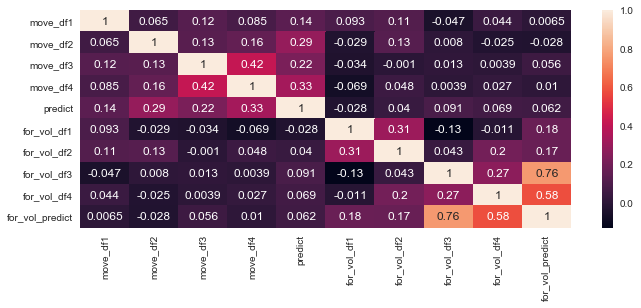

In [44]:
corrMatrix = mult_df_period.corr()
sn.heatmap(corrMatrix, annot=True)

In [45]:
fx_predictors = process_vols(sub_vol, sub2_vol, sub3_vol, sub4_vol)
fx_predictors

[0.003538, 0.005636, 0.002705, 0.004102]

In [46]:
predict_multiple(mult_df_period, 5, 4, fx_predictors)

The features used are:  ['for_vol_df1', 'for_vol_df2', 'for_vol_df3', 'for_vol_df4']
The predictors used are:  [0.003538, 0.005636, 0.002705, 0.004102]
The root mean square error is:  0.00013436036771972268
The root mean square error in vol is:  0.21
The R2 is:  0.8913300852015484
The degree is:  2
The predicted vol is:  4.72


## RUN Simple Regression

In [47]:
eur = read_format(file_one)
jpy = read_format(file_two)
bp =  read_format(file_three)
ca =  read_format(file_four)
au =  read_format(file_five)

In [48]:
simple_df = process_forward_regress_two(sub1, focus, number_of_days_to_sample )


In [49]:
simple_df_period = simple_df.tail(days_to_train)

In [50]:
simple_df_period.corr()

,for_vol_df1,for_vol_predict
for_vol_df1,1.000000,0.178615
for_vol_predict,0.178615,1.000000


In [51]:
fx_predictor = vol_convert(sub_vol)
fx_predictor

0.003538

In [52]:
predict(simple_df_period, 5, fx_predictor)

The root mean square error is:  0.0003796020045524854
The predictor used is:  0.003538
The root mean square error in vol is:  0.61
The R2 is:  0.13259094139817418
The degree is:  2
The feature vol is:  5.65
The predicted vol is:  5.77
The vol spread is: 0.12


## RUN SAMPLING ANALYSIS

In [53]:
sim_option_value(range_of_days, 10000, number_of_days_to_sample, atm_price, True)

0.001

In [54]:
hist_move_sampling(range_of_days, number_of_days_to_sample, 10000, focus_vol, True)

The date range includes 68 days
60 days were sampled, out of the 68 days
The mean vol is: 3.47
The standard deviation is: 0.33
The percentage of sample groups that had mean volatilities above 4.8 is: 0.0001
